<a href="https://colab.research.google.com/github/larissavvsous/Mineracao-de-Dados/blob/main/Aula_02_asl_cnn_UFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

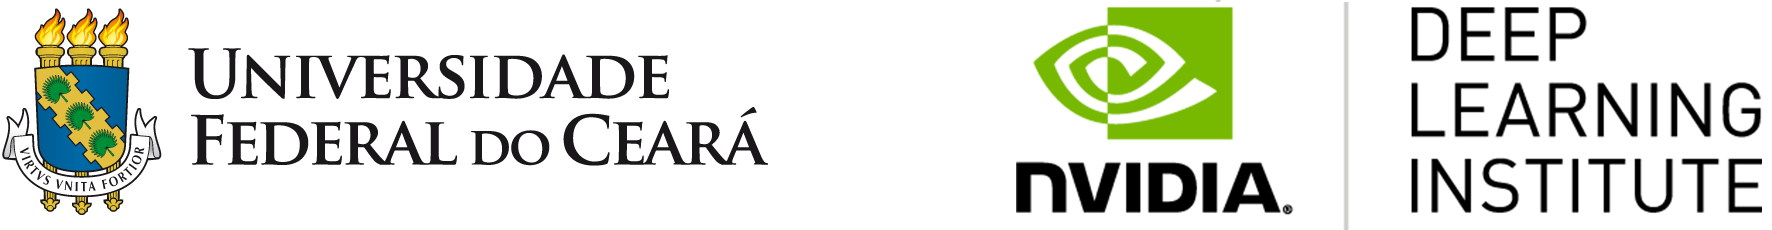

# Convolutional Neural Networks (CNN)


O modelo anteior foi capaz de aprender como classificar corretamente o conjunto de dados de treinamento com precisão muito alta, mas não teve um desempenho tão bom no conjunto de dados de validação. Esse comportamento de não generalizar bem para dados que não são de treinamento é chamado de [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html) e, nesta seção, apresentaremos um tipo popular de modelo chamado [rede neural convolucional](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) que é especialmente bom para ler imagens e classificá-las.
Executaremos as etapas de preparação de dados, criação de modelo e treinamento de modelo que observamos na última seção usando um conjunto de dados diferente: imagens de mãos fazendo letras na linguagem de sinais americana (ASL)
(http://www.asl.gs/).

## Objetivos

* Preparar dados especificamente para uma CNN
* Criar um modelo CNN mais sofisticado, compreendendo uma maior variedade de camadas de modelo
* Treinar um modelo CNN e observe seu desempenho

# American Sign Language Dataset

O alfabeto American Sign Language (http://www.asl.gs/) contém 26 letras. Duas dessas letras (j e z)
exigem movimento, portanto, não são incluídos no conjunto de dados de treinamento.

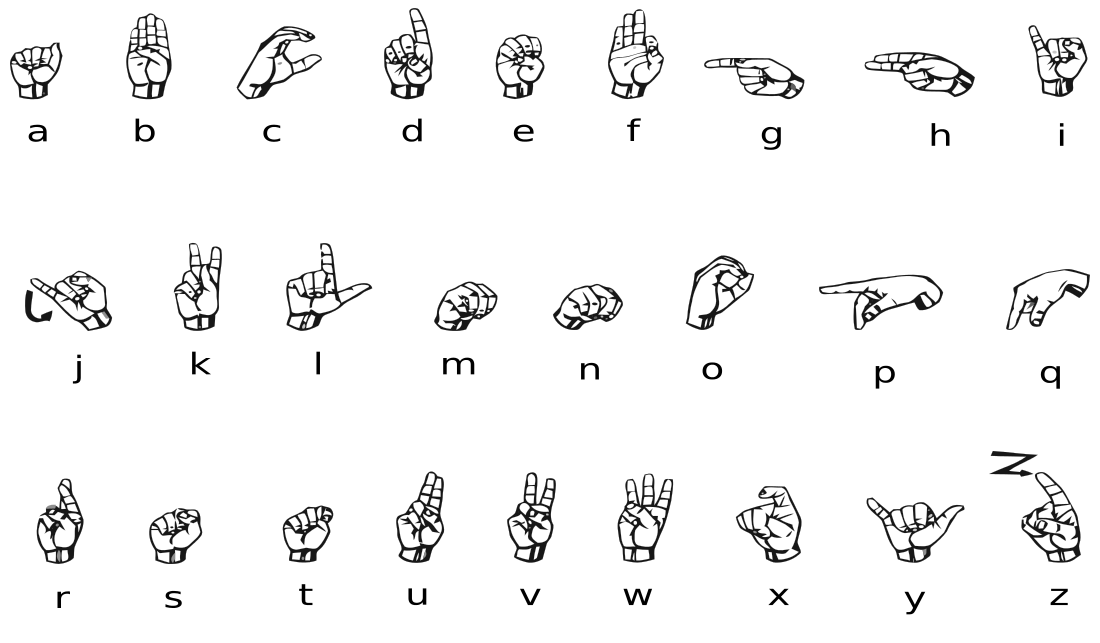

## Carregando e Preparando os Dados

A célula abaixo contém as técnicas de pré-processamento de dados que aprendemos nos laboratórios anteriores. Para fazer isto será necessário ter uma conta no Google drive e ter a seguinte estrutura.

**Criar a pasta  *Colab Notebooks* no seu Google drive. Adicione duas pastas dados \data  e \images,  e coloque os dados dentro delas conforme apresentado pelo professor.**

Revise-o antes de executar. Após execute-o para prosseguir:

In [1]:
import tensorflow.keras as keras
import pandas as pd
#O comando a seguir vai requerer autenticação no seu Google drive com a sua senha
from google.colab import drive
drive.mount('/content/drive')


# Load in our data from CSV files
train_df = pd.read_csv("/content/drive/MyDrive/data-mineracao/data/asl-data-20240123T134653Z-001/asl-data/sign_mnist_train.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/data-mineracao/data/asl-data-20240123T134653Z-001/asl-data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Remodelando as imagens para uma CNN

No último exercício, as imagens individuais em nosso conjunto de dados estão no formato de longas listas de 784 pixels:

In [2]:
x_train.shape, x_valid.shape

((27455, 784), (7172, 784))

Nesse formato, não temos todas as informações sobre quais pixels estão próximos uns dos outros. Por causa disso, não podemos aplicar convoluções que detectam feições. Vamos remodelar nosso conjunto de dados para que eles estejam em um formato de 28x28 pixels. Isso permitirá que nossas convoluções associem grupos de pixels e detectem recursos importantes.

Observe que para a primeira camada convolucional do nosso modelo, precisamos ter não apenas a altura e a largura da imagem, mas também o número de [canais de cores](https://www.photoshopessentials.com/essentials/rgb/) . Nossas imagens são em tons de cinza, então teremos apenas 1 canal.

Isso significa que precisamos converter a forma atual `(27455, 784)` para `(27455, 28, 28, 1)`. Por conveniência, podemos passar o método [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy.reshape) um `-1` para qualquer dimensão que desejamos permanece o mesmo, portanto:

In [3]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [4]:
x_train.shape

(27455, 28, 28, 1)

In [5]:
x_valid.shape

(7172, 28, 28, 1)

In [6]:
x_train.shape, x_valid.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

## Criando o modelo Convolucional

Atualmente, muitos cientistas de dados iniciam seus projetos pegando emprestado as propriedades do modelo de um projeto semelhante. Supondo que o problema não seja totalmente único, há uma grande chance de que as pessoas tenham criado modelos com bom desempenho, publicados em repositórios on-line como [TensorFlow Hub](https://www.tensorflow.org/hub) e o [Catálogo NGC ](https://ngc.nvidia.com/catalog/models). Hoje, forneceremos um modelo que funcionará bem para esse problema.

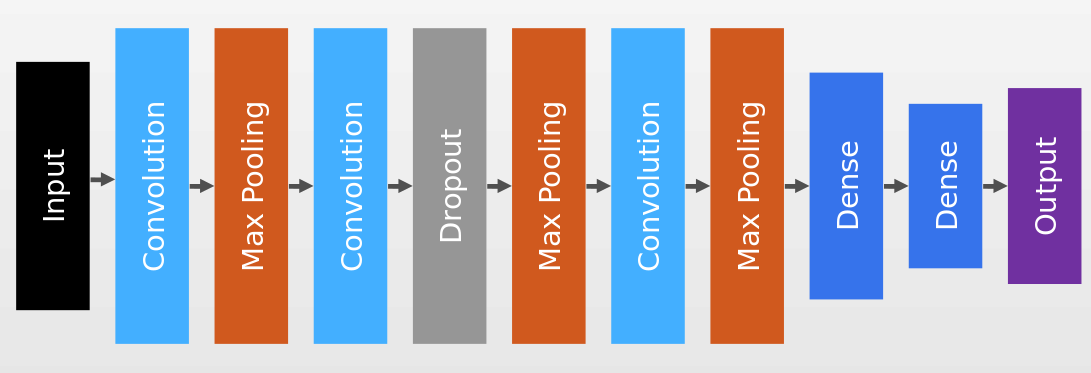

Cobrimos muitos dos diferentes tipos de camadas em aula, e vamos passar por todos eles aqui com links para suas documentações. Em caso de dúvida, leia a documentação oficial (ou pergunte [stackoverflow](https://stackoverflow.com/)).

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

### [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

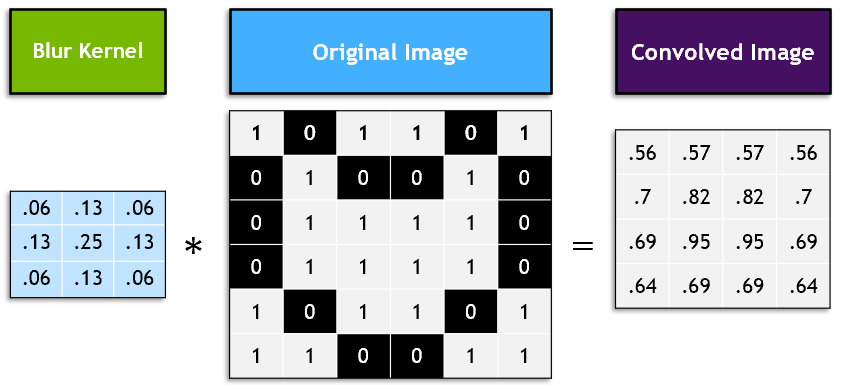

Estas são as nossas camadas convolucionais 2D. Os kernels pequenos irão examinar a imagem de entrada e detectar recursos que são importantes para a classificação. Convoluções anteriores no modelo detectarão recursos simples, como linhas. Convoluções posteriores detectarão recursos mais complexos. Vejamos nossa primeira camada Conv2D:
```Python
model.add(Conv2D(75 , (3,3) , passos = 1 , padding = 'mesmo'...)
```
75 refere-se ao número de filtros que serão aprendidos. (3,3) refere-se ao tamanho desses filtros. Os passos referem-se ao tamanho do passo que o filtro levará ao passar pela imagem. Preenchimento refere-se a se a imagem de saída criada a partir do filtro corresponderá ao tamanho da imagem de entrada.

### [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Assim como normalizar nossas entradas, a normalização em lote dimensiona os valores nas camadas ocultas para melhorar o treinamento. [Leia mais sobre isso em detalhes aqui](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/).

### [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

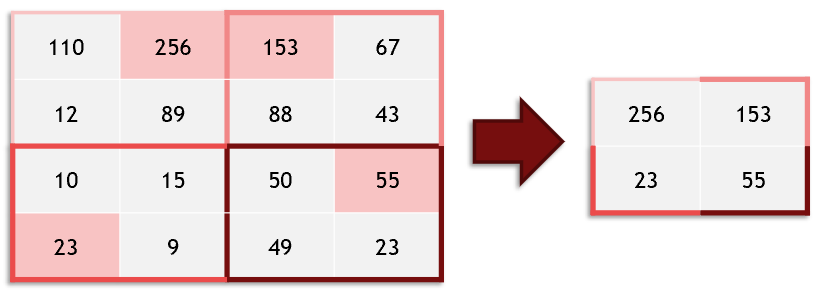

O pooling máximo pega uma imagem e basicamente a reduz para uma resolução mais baixa. Ele faz isso para ajudar o modelo a ser robusto à translação (objetos se movendo de um lado para o outro) e também torna nosso modelo mais rápido.

### [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

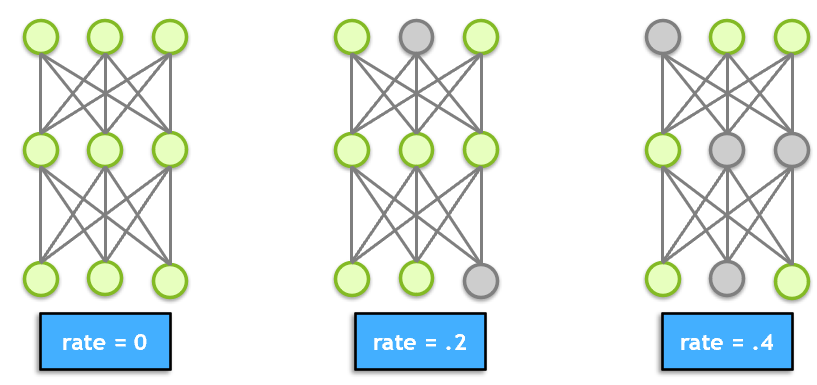

Dropout é uma técnica para prevenir overfitting. Dropout seleciona aleatoriamente um subconjunto de neurônios e os desliga, para que eles não participem da propagação para frente ou para trás naquele passe específico. Isso ajuda a garantir que a rede seja robusta e redundante e não dependa de nenhuma área para obter respostas.

### [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

Flatten pega a saída de uma camada que é multidimensional e a achata em uma matriz unidimensional. A saída é chamada de vetor de características e será conectada à camada de classificação final.

### [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

Já vimos camadas densas antes em nossos modelos anteriores. Nossa primeira camada densa (512 unidades) toma o vetor de recursos como entrada e aprende quais recursos contribuirão para uma classificação específica. A segunda camada densa (24 unidades) é a camada de classificação final que gera nossa previsão.

## Resumindo o Modelo

Isso pode parecer muita informação, mas não se preocupe. Não é crítico entender tudo agora para treinar efetivamente os modelos convolucionais. Mais importante, sabemos que eles podem ajudar na extração de informações úteis de imagens e podem ser usados em tarefas de classificação.

Aqui, resumimos o modelo que acabamos de criar. Observe como ele tem-se menos parâmetros treináveis do que o modelo do notebook anterior:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        2

## Compilando o Modelo

Vamos compilar o modelo como antes:

In [9]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

## Treinando o Modelo

Apesar da arquitetura do modelo ser muito diferente, o treinamento parece exatamente o mesmo. Execute a célula abaixo para treinar por 20 épocas e vamos ver se a precisão melhora:

In [10]:
history = model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/20
858/858 [==============================] - 18s 10ms/step - loss: 0.3052 - accuracy: 0.9057 - val_loss: 0.3321 - val_accuracy: 0.9103
Epoch 2/20
858/858 [==============================] - 5s 6ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.2806 - val_accuracy: 0.9204
Epoch 3/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.2252 - val_accuracy: 0.9339
Epoch 4/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.1915 - val_accuracy: 0.9522
Epoch 5/20
858/858 [==============================] - 5s 6ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.3130 - val_accuracy: 0.9336
Epoch 6/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.4056 - val_accuracy: 0.9000
Epoch 7/20
858/858 [==============================] - 5s 6ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.2012 - val_accuracy: 0.9483
Epoc

# Plotando os Resultados

(0.0, 0.8)

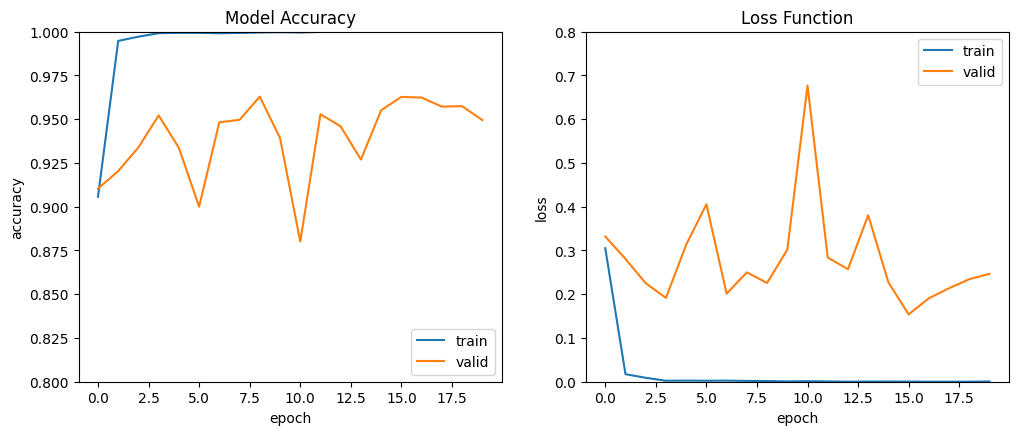

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0.8, 1)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.ylim([0,.8])

### Atividade: Matriz de confusão

225/225 [==============================] - 1s 2ms/step


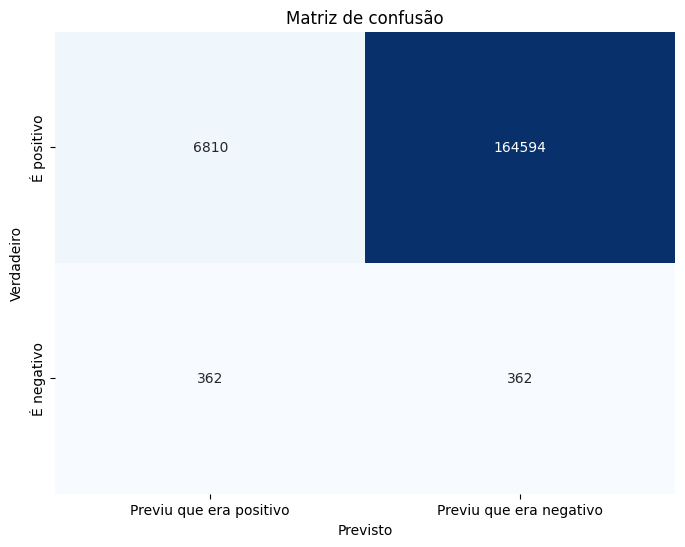

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

labels = ['Verdadeiro positivo', 'Verdadeiro negativo', 'Falso positivo', 'Falso negativo']
values = [np.sum(TP), np.sum(TN), np.sum(FP), np.sum(FN)]

conf_matrix_df = pd.DataFrame([values[:2], values[2:]], index=['É positivo', 'É negativo'], columns=['Previu que era positivo', 'Previu que era negativo'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

## Discussão dos Resultados

Parece que este modelo foi significativamente melhorado! A precisão do treinamento é muito alta e a precisão da validação também melhorou. Este é um bom resultado, pois tudo o que tivemos que fazer foi trocar por um novo modelo.

Você deve ter notado a precisão da validação está saltando. Isso é uma indicação de que nosso modelo ainda não está generalizando perfeitamente. Felizmente, há mais alguma coisa que podemos fazer. **Podemos usar uma técnica de aumento dos dados chamada Data Augmentation.**

## Resumo

Nesta seção, utilizamos vários novos tipos de camadas para implementar uma CNN, que teve um desempenho melhor do que o modelo mais simples usado na última seção.

## Limpe a memória

Antes de prosseguir, execute a célula a seguir para limpar a memória da GPU. Isso é necessário para passar para o próximo notebook.

In [13]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Next

Nas últimas seções, você se concentrou na criação e no treinamento de modelos. Para melhorar ainda mais o desempenho, agora você voltará sua atenção para o *data augmentation*, uma coleção de técnicas que permitirá que seus modelos treinem com mais e melhores dados do que os que você poderia ter originalmente à sua disposição.

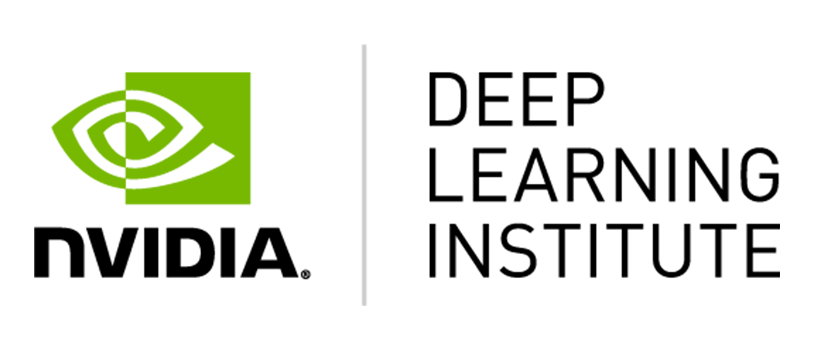